In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [5]:
data = pd.read_csv("../data/output.csv",header=0)
data.head(2)

,bunji,lat,lng,1975_1,1975_2,1975_3,1975_4,1976_1,1976_2,1976_3,...,2021_1,2021_2,2021_3,2021_4,2022_1,2022_2,2022_3,2022_4,2023_1,2023_2
0,서울특별시 광진구 중곡동 628-3,127.077431,37.559874,0.0,0.0,0.0,0.054827,0.087919,0.087919,0.087919,...,1.411861,1.411861,1.421807,1.372022,1.353743,1.269074,1.269074,1.269074,1.247907,1.247907
1,서울특별시 광진구 중곡동 628-17,127.077477,37.559968,0.0,0.0,0.0,0.055127,0.088543,0.088543,0.088543,...,1.418135,1.418135,1.427998,1.377930,1.359546,1.274550,1.274550,1.274550,1.253300,1.253300


In [18]:
test = data.values[0]
bunji = test[0].split(" ")[2:]
''.join(bunji)

'중곡동628-3'

In [20]:
s = "1995-01-01 00:00:00"
pd.to_datetime(s)

Timestamp('1995-01-01 00:00:00')

In [25]:
for row in data.values:
    try:
        # list(dict)에 values의 요소들을 하나씩 추가
        new = list(dict())
        years = 1975
        month = ["01","04","07","10"]
        j = 0
        for i in range(6,len(row)):
            if(j==4):
                j=0
            new.append({"date":pd.to_datetime("{}-{}-01 00:00:00".format(years,month[j])),
                       "risk":row[i]})
            if(j==3):
                years+=1
            j+=1

        # 변수명에 저장
        new = pd.DataFrame(new)
        bunji = row[0].split(" ")[2:]
        new.to_csv(f"../data/outputs/{''.join(bunji)}.csv",index=False,encoding="cp949")
    except Exception:
        print(row[0])

# 시계열 데이터 불러오기 

In [26]:
risk = pd.read_csv("../data/outputs/중곡동16.csv",header=0)
risk.head(2)

,date,risk
0,1975-01-01,0.090656
1,1975-04-01,0.158677


In [30]:
risk["date"] = pd.to_datetime(risk['date'])

In [31]:
risk = risk.sort_values(by='date')
risk.info

<bound method DataFrame.info of           date      risk
0   1975-01-01  0.090656
1   1975-04-01  0.158677
2   1975-07-01  0.158677
3   1975-10-01  0.158677
4   1976-01-01  0.158677
..         ...       ...
186 2021-07-01  1.865217
187 2021-10-01  1.865217
188 2022-01-01  1.865217
189 2022-04-01  1.836143
190 2022-07-01  1.836143

[191 rows x 2 columns]>

### train test 데이터를 8:2 비율로 나눔

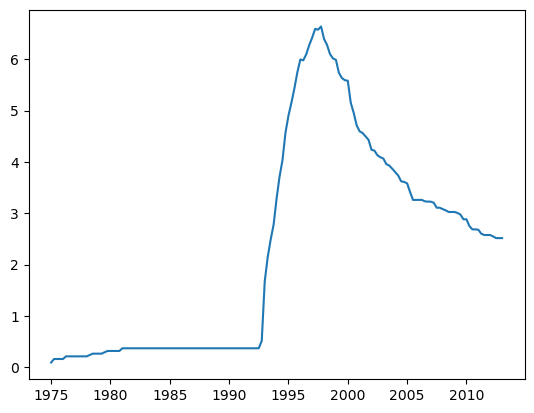

In [33]:
train = risk[0:153]
test = risk[153:]
plt.plot(train['date'],train['risk'])
plt.show()

### 차분

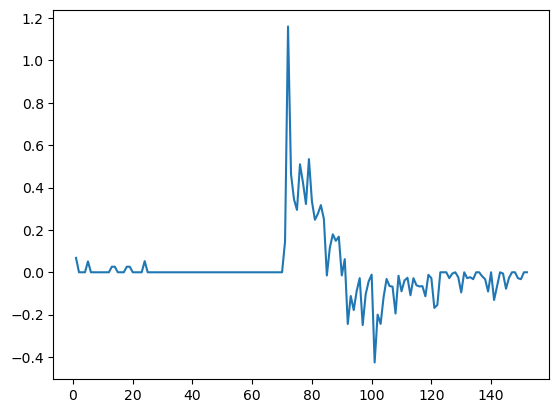

In [34]:
diff_1 = train['risk'].diff().dropna()
plt.plot(diff_1)
plt.show()

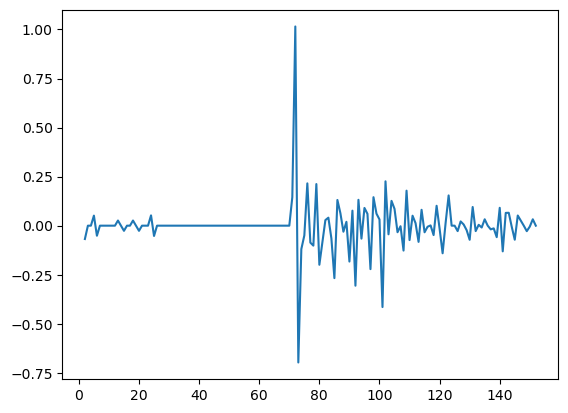

In [62]:
diff_2 = diff_1.diff().dropna()
plt.plot(diff_2)
plt.show()

In [37]:
def acf(series, k):
    mean = series.mean()
    denominator = np.sum(np.square(series-mean))
    numerator = np.sum((series-mean)*(series.shift(k)-mean))
    acf_val = numerator/denominator
    return acf_val
 
def pacf(series, k):
    if k == 0:
        pacf_val = 1
    else:
        gamma_array = np.array([acf(series, k) for k in range(1,k+1)])
 
        gamma_matrix = []
        for i in range(k):
            temp = [0]*k
            temp[i:] = [acf(series, j) for j in range(k-i)]
            gamma_matrix.append(temp)
 
        gamma_matrix = np.array(gamma_matrix)
        gamma_matrix = gamma_matrix + gamma_matrix.T - np.diag(gamma_matrix.diagonal())
        pacf_val = np.linalg.inv(gamma_matrix).dot(gamma_array)[-1]
    return pacf_val

### ACF

ACF값이 점차적으로 감소하므로 자기 회귀 모델로 설명할 수 있다.

C:\Users\songkyu\AppData\Local\Temp\ipykernel_9516\186236550.py:8: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  markers, stemlines, baseline = plt.stem(x, acfs, use_line_collection=True)


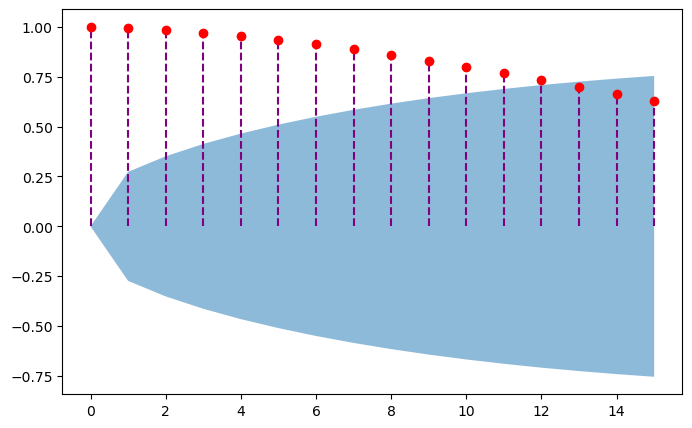

In [69]:
nlags = 15
acfs = [acf(train['risk'],k) for k in range(nlags+1)]
x = range(nlags+1)
fig = plt.figure(figsize=(8,5))
fig.set_facecolor('white')
 
## correlogram
markers, stemlines, baseline = plt.stem(x, acfs, use_line_collection=True)
markers.set_color('red')
stemlines.set_linestyle('--')
stemlines.set_color('purple')
baseline.set_visible(False) ## base line 안보이게
 
n = len(train)
upper_limit = []
lower_limit = []
for k in x:
    if k == 0:
        upper_limit.append(0)
        lower_limit.append(0)
    else:
        term1 = np.sqrt((1+2*np.sum(np.square(acfs[1:k+1])))/n)
        upper_limit.append(1.96*term1)
        lower_limit.append(-1.96*term1)
 
plt.fill_between(x, lower_limit, upper_limit, alpha=0.5)
plt.show()

### PACF

2차에서 PACF 값이 급격히 감소하므로, 자기 회귀 모델의 차수는 2차이다.

C:\Users\songkyu\AppData\Local\Temp\ipykernel_9516\1619253339.py:8: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  markers, stemlines, baseline = plt.stem(x, pacfs, use_line_collection=True)


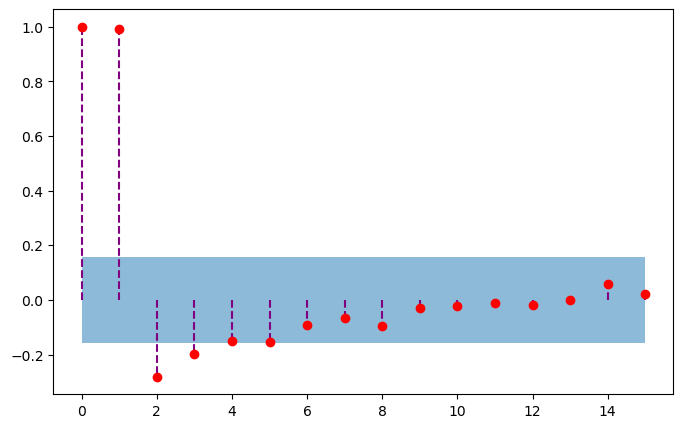

In [68]:
nlags = 15
pacfs = [pacf(train['risk'],k) for k in range(nlags+1)]
x = range(nlags+1)
fig = plt.figure(figsize=(8,5))
fig.set_facecolor('white')
 
## correlogram
markers, stemlines, baseline = plt.stem(x, pacfs, use_line_collection=True)
markers.set_color('red')
stemlines.set_linestyle('--')
stemlines.set_color('purple')
baseline.set_visible(False) ## base line 안보이게
 
n = len(train)
upper_limit = 1.96/np.sqrt(n)
lower_limit = -1.96/np.sqrt(n)
plt.fill_between(x, lower_limit, upper_limit, alpha=0.5)
plt.show()

### statsmodels로 ACF, PACF 구하기

In [80]:
train_acf = sm.tsa.stattools.acf(train['risk'],nlags=15,fft=False)
train_pacf = sm.tsa.stattools.pacf(train['risk'],nlags=15,method='ols')
print(train_acf,train_pacf)

[1.         0.99348247 0.98334957 0.96993259 0.95345027 0.93374321
 0.91133902 0.88656276 0.85917911 0.82989359 0.79897906 0.76674681
 0.7332907  0.69901057 0.66473506 0.63042202] [ 1.          0.99356173 -0.66709987 -0.23017944 -0.17253569 -0.24301654
 -0.04673032  0.04220567 -0.18575778  0.18427799  0.01770304  0.01277168
  0.04156476  0.05975549  0.15645177  0.00289383]


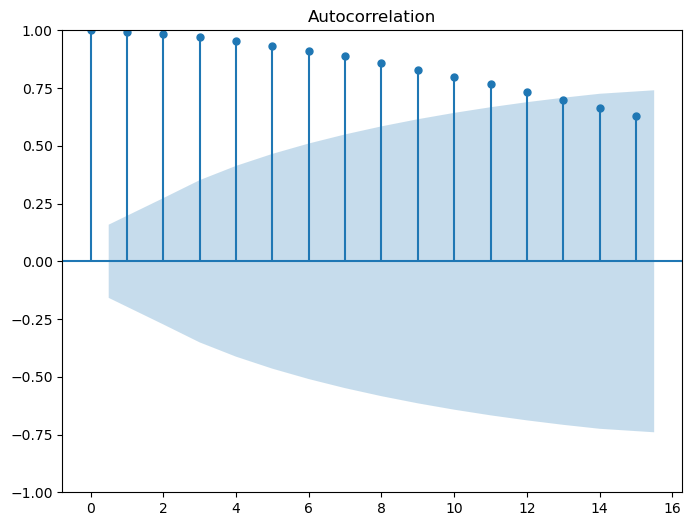

In [77]:
fig = plt.figure(figsize=(8,6))
fig.set_facecolor('white')
ax = fig.add_subplot()
sm.graphics.tsa.plot_acf(train['risk'], lags=15, ax=ax)
plt.show()

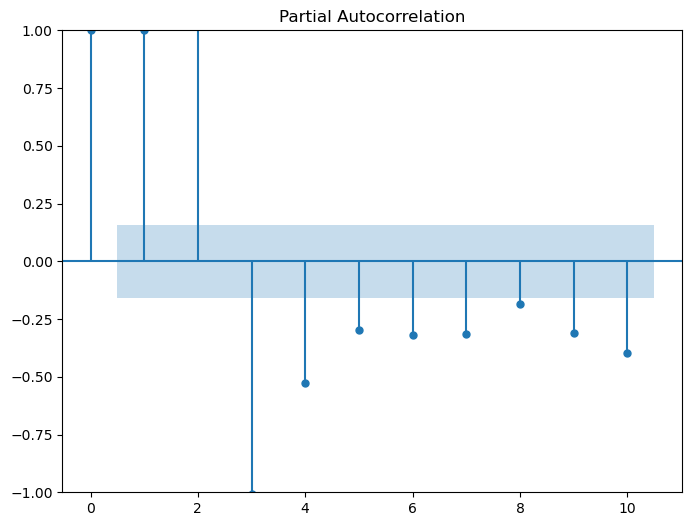

In [81]:
fig = plt.figure(figsize=(8,6))
fig.set_facecolor('white')
ax = fig.add_subplot()
sm.graphics.tsa.plot_pacf(train['risk'], lags=10, ax=ax)
plt.show()

## 시계열 데이터가 비선형적 구조, 정규분포를 따르지 않는 구조라면, 직접 만든 공식이 더 정확하다.

# ARIMA(1,2,0) model

In [94]:
sm.__version__

'0.13.5'

In [96]:
# from statsmodels.tsa.arima_model import ARIMA
model = sm.tsa.arima.ARIMA(train['risk'],order=(1,2,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   risk   No. Observations:                  153
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 104.842
Date:                Tue, 02 May 2023   AIC                           -205.685
Time:                        17:53:03   BIC                           -199.650
Sample:                             0   HQIC                          -203.233
                                - 153                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3497      0.033    -10.581      0.000      -0.415      -0.285
sigma2         0.0146      0.000     37.734      0.000       0.014       0.015
Ljung-Box (L1) (Q):                   1.13   Jarque-

## 예측

In [100]:
forecast = model_fit.forecast(steps=len(test))
forecast

153    2.514415
154    2.514415
155    2.514415
156    2.514415
157    2.514415
158    2.514415
159    2.514415
160    2.514415
161    2.514415
162    2.514415
163    2.514415
164    2.514415
165    2.514415
166    2.514415
167    2.514415
168    2.514415
169    2.514415
170    2.514415
171    2.514415
172    2.514415
173    2.514415
174    2.514415
175    2.514415
176    2.514415
177    2.514415
178    2.514415
179    2.514415
180    2.514415
181    2.514415
182    2.514415
183    2.514415
184    2.514415
185    2.514415
186    2.514415
187    2.514415
188    2.514415
189    2.514415
190    2.514415
Name: predicted_mean, dtype: float64

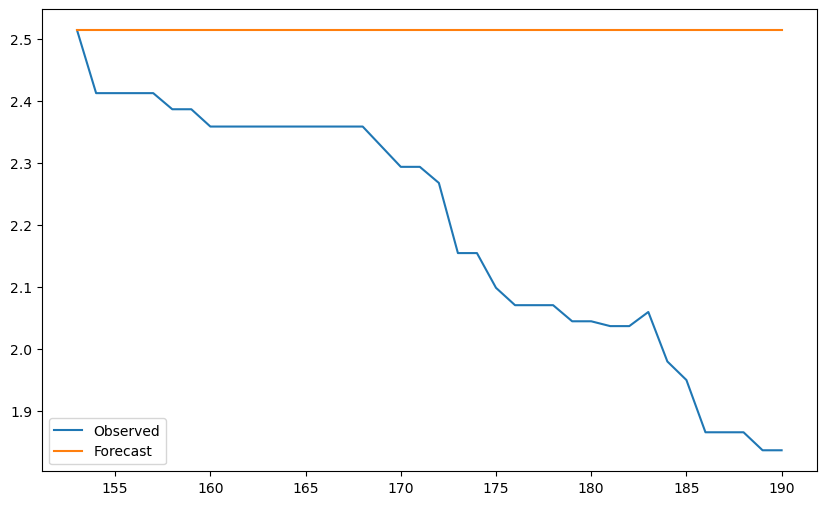

In [102]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(test['risk'], label='Observed')
ax.plot(np.arange(len(train), len(train)+len(test)), forecast, label='Forecast')
ax.legend()
plt.show()